# Identifying Gaps in the Beacon Data
Prior to imputation, we want to identify gaps in the Beacon data that we can hopefully fill. This notebook is aimed at identifying the quantity and quality of those gaps.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
import missingno as msno

from datetime import datetime, timedelta


# Data Import
We want all the measurements made by the beacon - not just the nightly concentrations.

In [3]:
data = pd.read_csv("../data/processed/beacon-ux_s20.csv", parse_dates=["timestamp"],index_col="timestamp",infer_datetime_format=True)
# dropping the unecessary columns and NaNs from all sensors
data.drop(["beacon","fitbit","redcap","no2","lux"],axis="columns",inplace=True)
data.dropna(subset=[col for col in data.columns if col not in ["beacon","beiwe","lux"]],how="all",inplace=True)
data.head()

,tvoc,co,co2,pm1_number,pm2p5_number,pm10_number,pm1_mass,pm2p5_mass,pm10_mass,temperature_c,rh,beiwe
timestamp,,,,,,,,,,,,
2020-06-08 13:00:00,311.378211,19.834244,NaN,12.081799,11.458559,50.644869,0.744280,24.767709,1.935866,16.244700,46.586667,kyj367pi
2020-06-08 13:02:00,311.568315,19.815803,NaN,12.157965,11.542477,51.183263,0.750738,25.379307,1.940782,16.257887,46.581250,kyj367pi
2020-06-08 13:04:00,312.426991,19.799258,NaN,12.044653,11.436841,50.524264,0.742682,24.874103,1.937115,16.269523,46.597059,kyj367pi
2020-06-08 13:06:00,313.341263,19.775693,NaN,12.019940,11.401453,50.289271,0.739928,24.503767,1.933971,16.279865,46.619444,kyj367pi
2020-06-08 13:08:00,314.082658,19.761017,NaN,12.040436,11.431434,50.488835,0.742263,24.824221,1.936699,16.289119,46.639474,kyj367pi


# Determining Gaps
We can determine gaps by looking at each of the pollutants, finding instances when the values are `NaN`, and then using a `t_diff` column which counts the difference in subsequent measurements. 

## Time Differences
Getting the time differences between measurements because we only want to consider consecutive measurements. 

Some Resources Used:
* [Check for Datetime Instance](https://stackoverflow.com/questions/25797245/how-to-properly-add-hours-to-a-pandas-tseries-index-datetimeindex)
* [Apply t Offest to Datetime Index](https://stackoverflow.com/questions/25797245/how-to-properly-add-hours-to-a-pandas-tseries-index-datetimeindex)

In [4]:
def add_t_diff(df):
    """
    Adds the t_diff column to the given dataframe
    """
    if not isinstance(df.index, pd.DatetimeIndex):
        try:
            df.set_index("timestamp") # typical column
        except KeyError:
            print("Index is not Datetime and `timestamp` does not exist in dataframe")
            return
        
    df["t_diff"] = ((df.index + pd.DateOffset(minutes=2)) - df.index).total_seconds()

## Getting Gaps per Participant per IEQ Parameter
Now we loop through each participant and then each IEQ parameter and find the periods when the `t_diff` is greater than 120 seconds.

Resources Used:
* [_Excellent_ Solution to Find "Chunks" of Similar Rows in DataFrame](https://stackoverflow.com/questions/54401560/chunking-dataframe-by-gaps-in-datetime-index)

In [5]:
pt_gaps = {}
for pt in data["beiwe"].unique():
    pt_bw = data[data["beiwe"] == pt]
    add_t_diff(pt_bw)
    ieq_dict = {}
    for ieq_param in data[[col for col in data.columns if col not in ["beacon","beiwe"]]].columns:
        pt_bw_ieq = pt_bw[pt_bw[ieq_param].isna()]
        if len(pt_bw_ieq) > 0:
            pt_bw_ieq['identifier']=(~pt_bw_ieq.index.to_series().diff().dt.seconds.div(120, fill_value=0).lt(2)).cumsum()
            d = {}
            for i,grp in pt_bw_ieq.groupby('identifier'):
                d.update(dict([(f"p{i}",grp)]))
            ieq_dict[ieq_param] = d
        else:
            ieq_dict[ieq_param] = {}
            
    pt_gaps[pt] = ieq_dict

## Examining Results

### Dictionary Inspection
Only looking at one participant's results because the dictionary is large and take a long time to load in.

In [6]:
pt_gaps["kyj367pi"]

{'tvoc': {'p0':                      tvoc        co         co2  pm1_number  pm2p5_number  \
  timestamp                                                                   
  2020-06-19 04:36:00   NaN  3.614709  634.639123   11.599790     10.994240   
  2020-06-19 04:38:00   NaN  3.630639  636.130882   11.607053     11.011092   
  2020-06-19 04:40:00   NaN  3.639447  637.402365   11.565274     10.978969   
  2020-06-19 04:42:00   NaN  3.648130  638.539944   11.383433     10.833993   
  2020-06-19 04:44:00   NaN  3.650265  639.520189   11.167132     10.673873   
  2020-06-19 04:46:00   NaN  3.647349  640.275325   11.067639     10.596226   
  2020-06-19 04:48:00   NaN  3.638768  640.782265   10.915692     10.502931   
  2020-06-19 04:50:00   NaN  3.639557  641.128566   10.795671     10.401224   
  2020-06-19 04:52:00   NaN  3.634543  641.336187   10.708314     10.334057   
  2020-06-19 04:54:00   NaN  3.645629  641.483798   10.642380     10.293026   
  2020-06-19 04:56:00   NaN  3.661871 

### Visualizing a Gap Instance
Seeing if the algorithm above worked correctly.

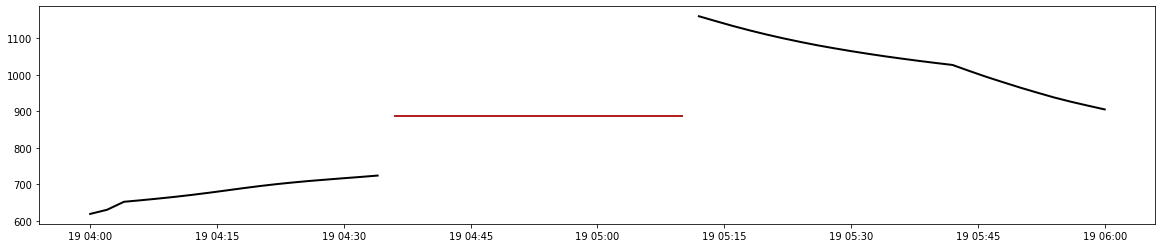

In [7]:
# getting some test data and filtering it to smaller time period
test = data[data["beiwe"] == "kyj367pi"]
test = test[datetime(2020,6,19,4):datetime(2020,6,19,6)]
# getting gap period
gap = pt_gaps["kyj367pi"]["tvoc"]["p0"]
gap.fillna(test["tvoc"].mean(),inplace=True) # mean value imputation'
# plotting
_, ax = plt.subplots(figsize=(20,4))
ax.plot(test.index,test["tvoc"],lw=2,color="black")
ax.plot(gap.index,gap["tvoc"],lw=2,color="firebrick")
plt.show()
plt.close()

<div class="alert-block alert alert-success">
    
The algorithm does seem to correctly identify the gaps in IEQ measurements. 
    
</div>

# Finding Exemplary Beacon Data
Looking for participant(s) with nearly complete datasets.

The process includes:
1. Adding in any missing datetime indices between the first and last entry for each participant - see solution [here](https://stackoverflow.com/questions/19324453/add-missing-dates-to-pandas-dataframe)
2. Determining the number of null values for each variable - see solution [here](https://chartio.com/resources/tutorials/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe/)
3. Create some metric to determine which participant is best
4. Further review the top candidates with `missingno`

## Looking at Participants

In [8]:
def get_n_missing(df_in):
    """
    
    """
    res = {"beiwe":[],"missing_mean":[],"missing_sum":[],"n":[]}
    df = df_in.copy()
    for pt in df["beiwe"].unique():
        df_pt = df[df["beiwe"] == pt]
        for col in ["pm1_number","pm2p5_number","pm10_number","pm1_mass","pm10_mass","rh","beiwe"]:
            try:
                df_pt.drop(col,axis="columns",inplace=True)
            except KeyError:
                pass
        idx = pd.date_range(df_pt.index[0],df_pt.index[-1],freq="2T")
        df_pt = df_pt.reindex(idx, fill_value=np.nan)
        missing = df_pt.isnull().sum()/len(df_pt)
        #print(df_pt.isnull().sum()/len(df_pt))
        for key, val in zip(res.keys(),[pt,np.sum(missing),np.mean(missing),len(df_pt)]):
            res[key].append(val)
    
    return pd.DataFrame(res).sort_values("missing_sum")

In [9]:
missing_res = get_n_missing(data)
missing_res.head()

,beiwe,missing_mean,missing_sum,n
19,rnse61g4,0.025404,0.005081,51133
23,4i7679py,0.029300,0.005860,36450
16,tmexej5v,0.045953,0.009191,50682
14,awa8uces,0.046384,0.009277,57304
4,xlw5ntd5,0.053689,0.010738,67668


<div class="alert-block alert alert-success">
    
We seem to have good participants we can consider:
    
</div>

## Inspecting Top Results

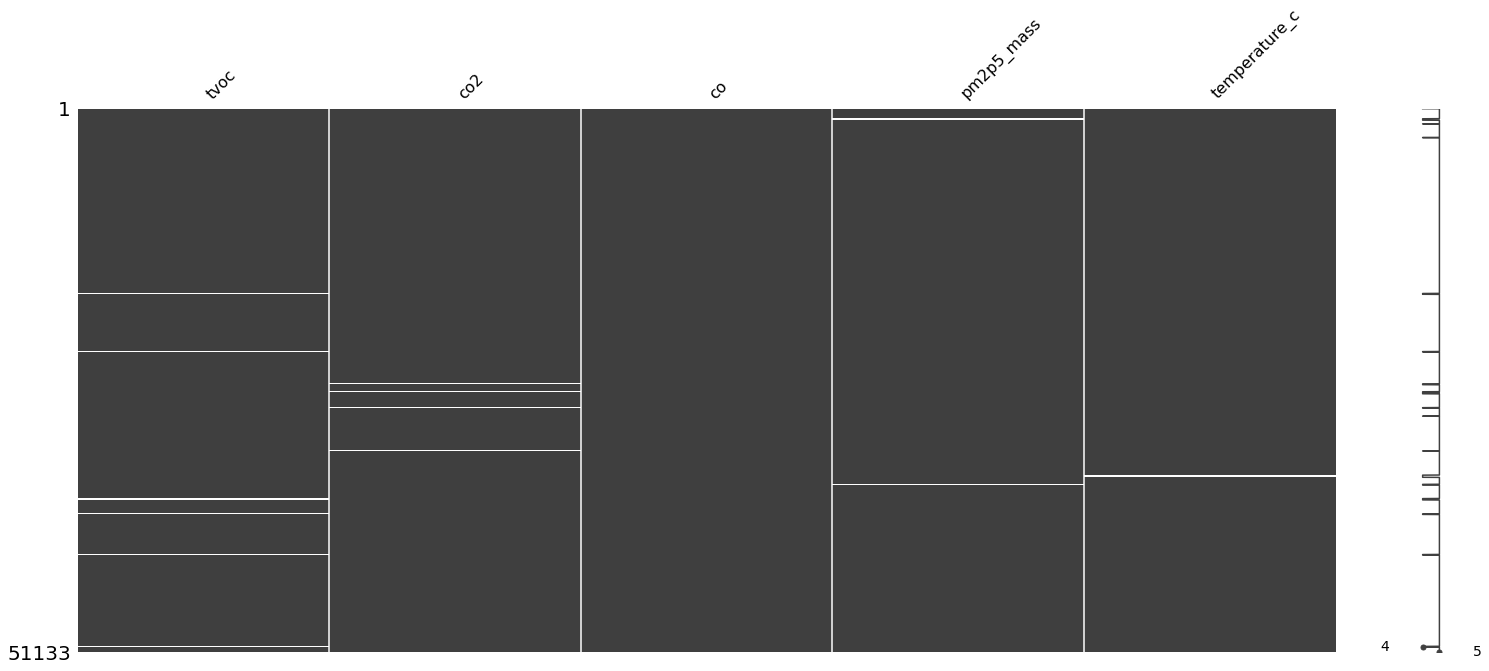

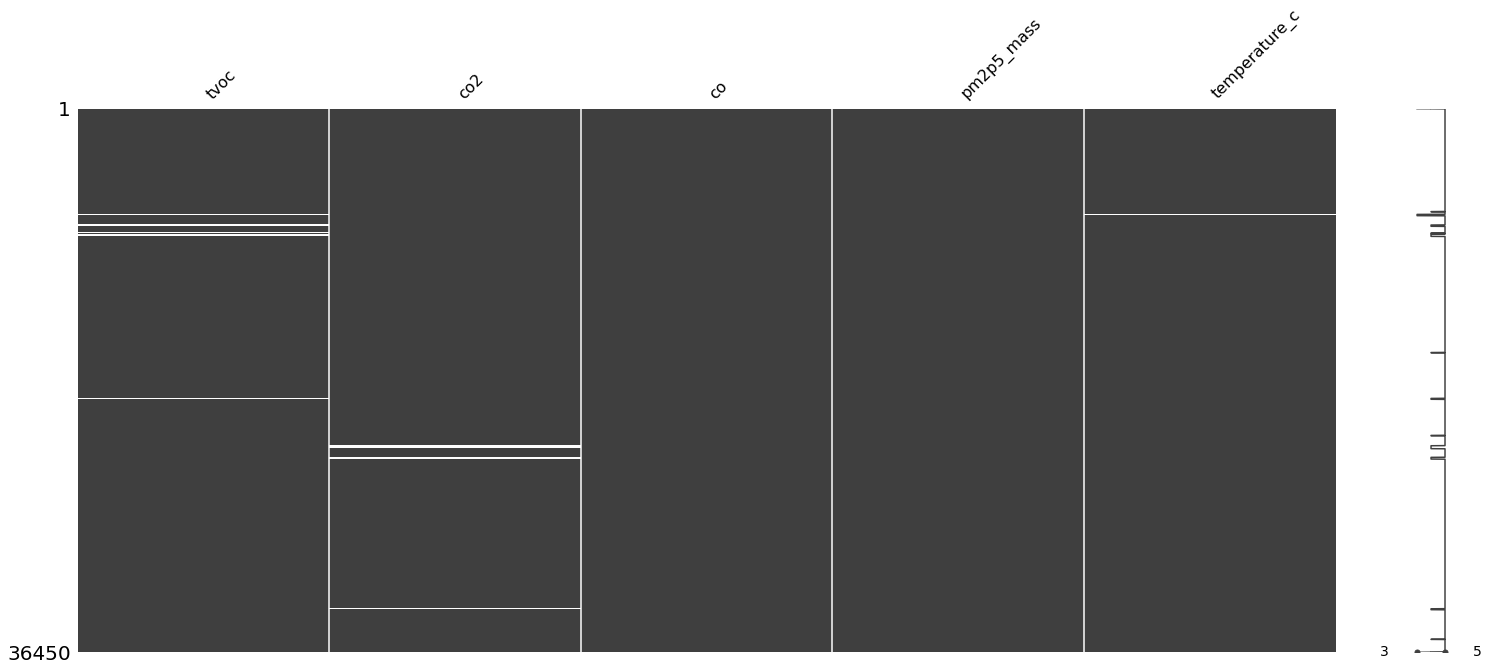

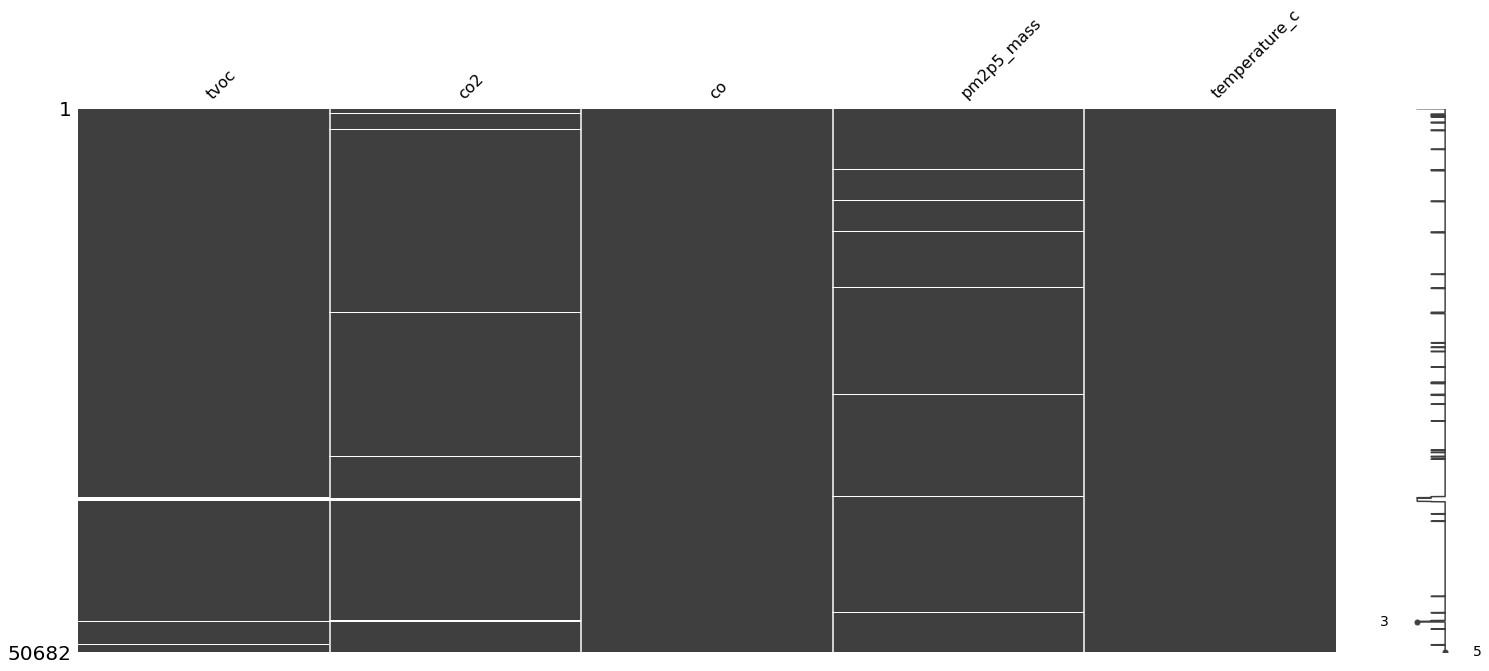

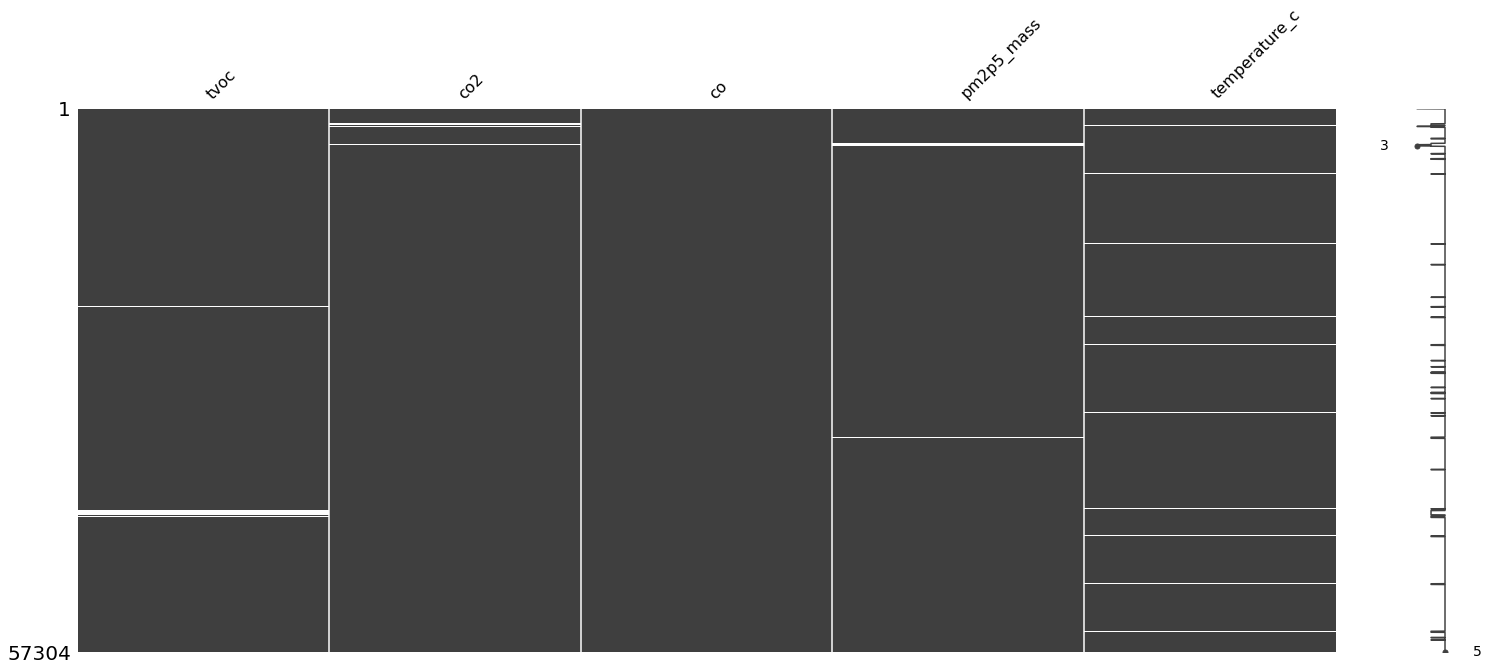

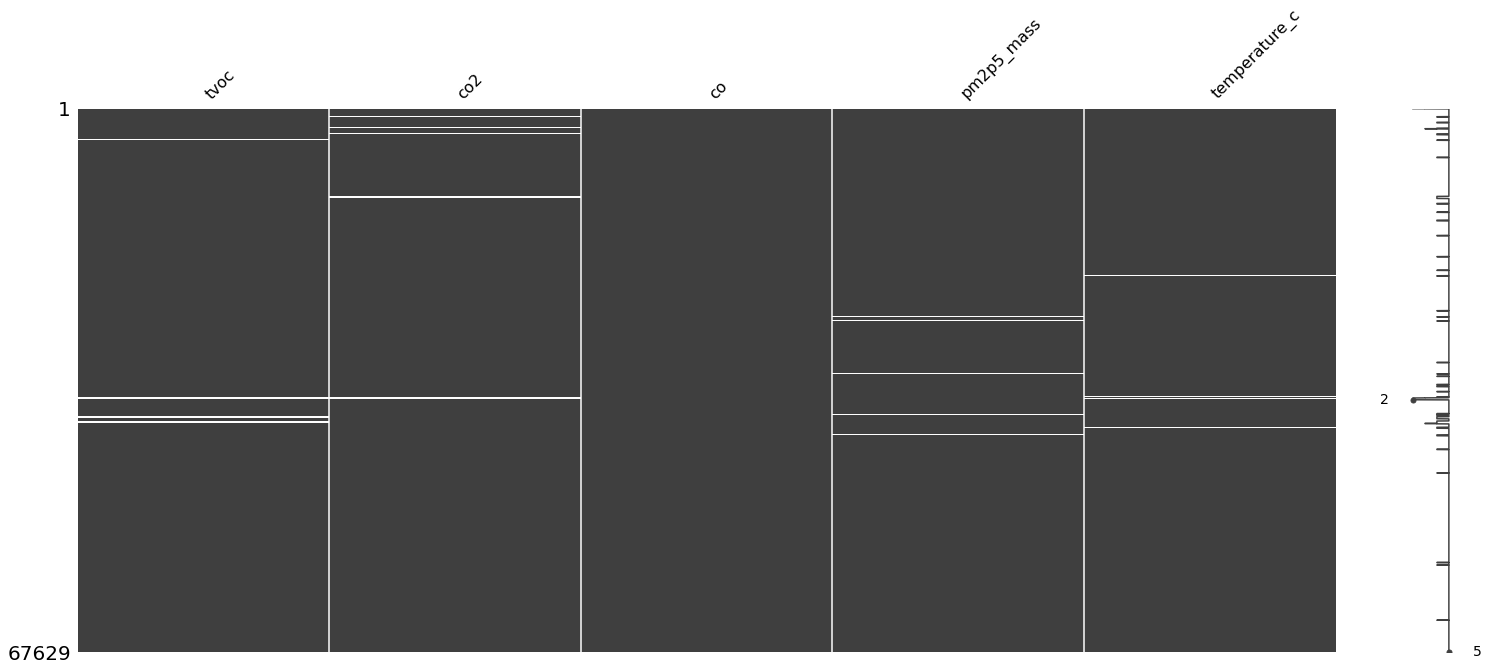

In [10]:
for pt in ["rnse61g4","4i7679py","tmexej5v","awa8uces","xlw5ntd5"]:
    data_pt = data[data["beiwe"] == pt]
    msno.matrix(data_pt[["tvoc","co2","co","pm2p5_mass","temperature_c"]])

## Interpolating the Missing Values from Top Results
We want to see if we can _safely_ impute some of the missing data to get an even more perfect dataset.

In [11]:
def manual_inspection(df_in,ieq_param,start_time=None,end_time=None):
    """
    Plots the timeseries of the data for a given parameter and highlights the null location
    """
    df_interp = df_in[ieq_param].interpolate()
    df_good = df_in[ieq_param].dropna()
    df_bad = df_in[df_in[ieq_param].isnull()][ieq_param]
    df_bad.fillna(0,inplace=True)
    _, ax = plt.subplots(figsize=(25,5))
    ax.scatter(df_good.index,df_good.values,color="seagreen",s=5,zorder=2)
    ax.scatter(df_bad.index,df_bad.values,color="firebrick",s=5,zorder=3)
    ax.scatter(df_interp.index,df_interp.values,color="black",s=5,zorder=1)
    if start_time == None:
        ax.set_xlim(left=df_good.index[0])
    else:
        ax.set_xlim(left=start_time)
        
    if end_time == None:
        ax.set_xlim(right=df_good.index[-1])
    else:
        ax.set_xlim(right=end_time)
        
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
    ax.set_title(ieq_param.upper())
    
    plt.show()
    plt.close()
    return df_bad

rnse61g4


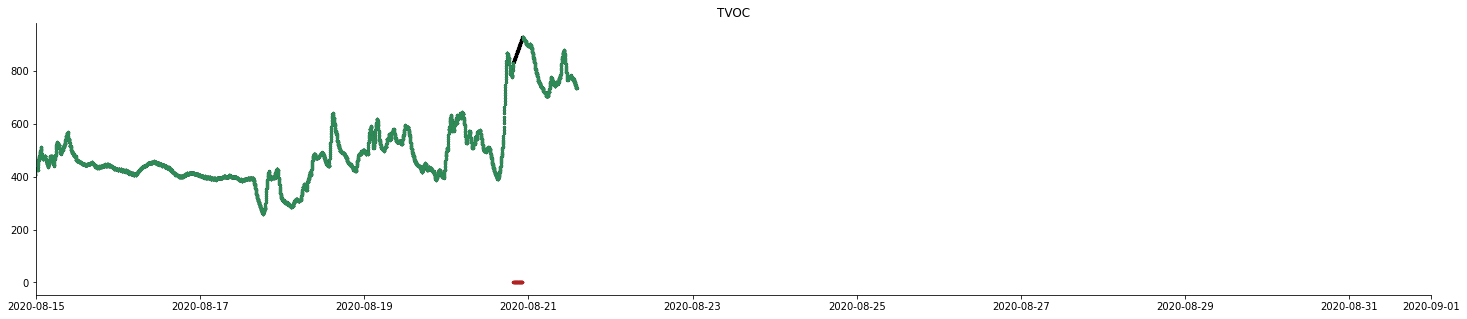

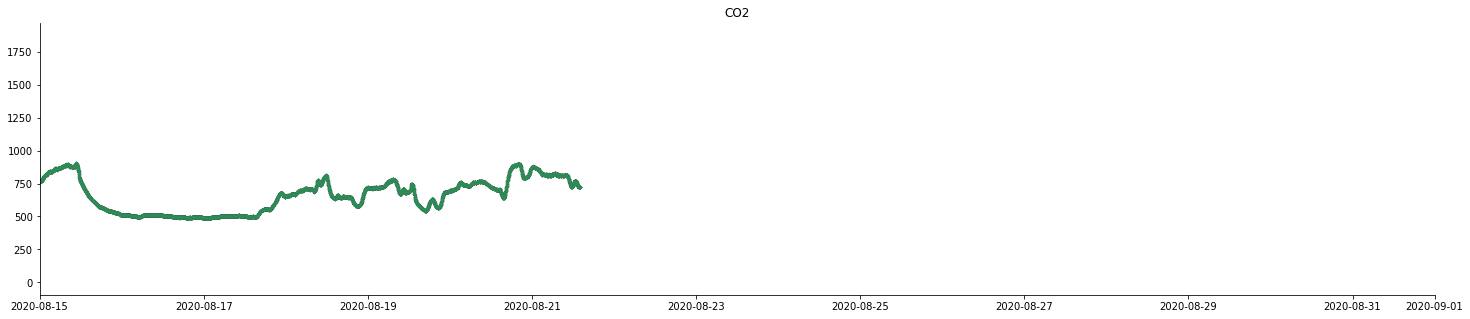

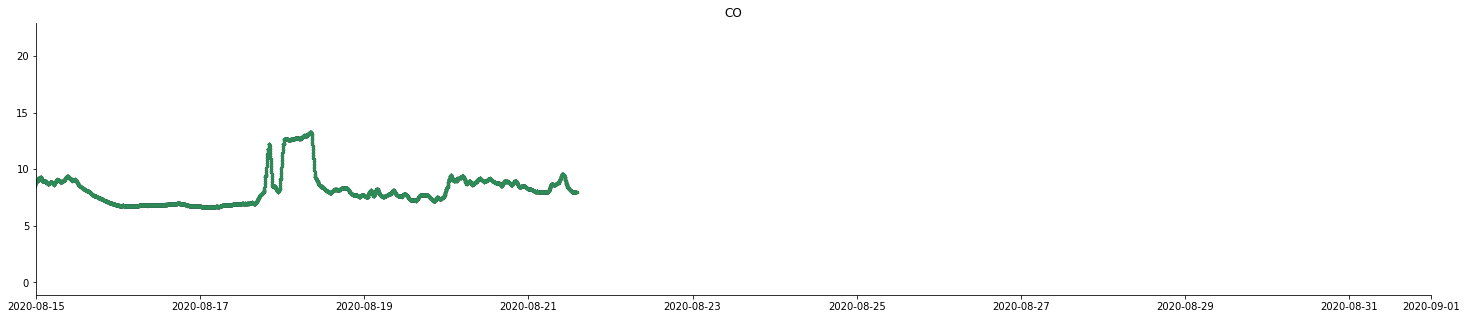

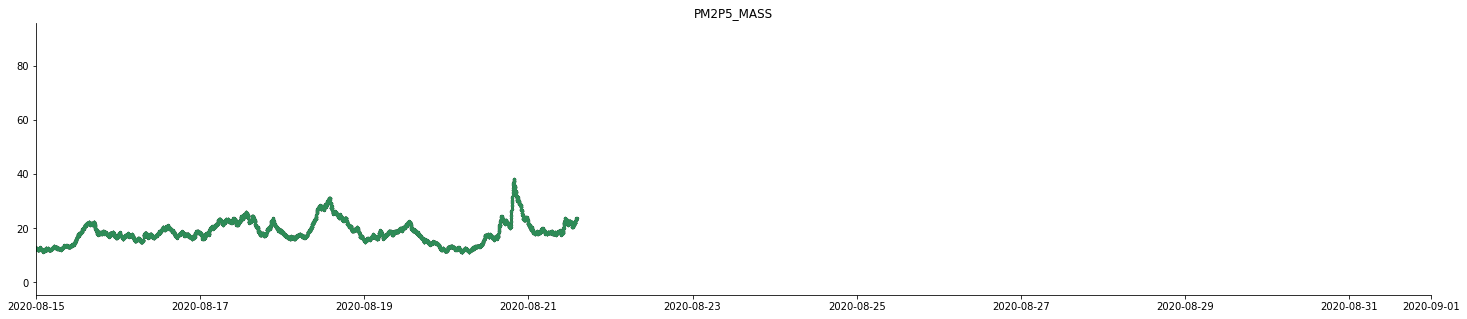

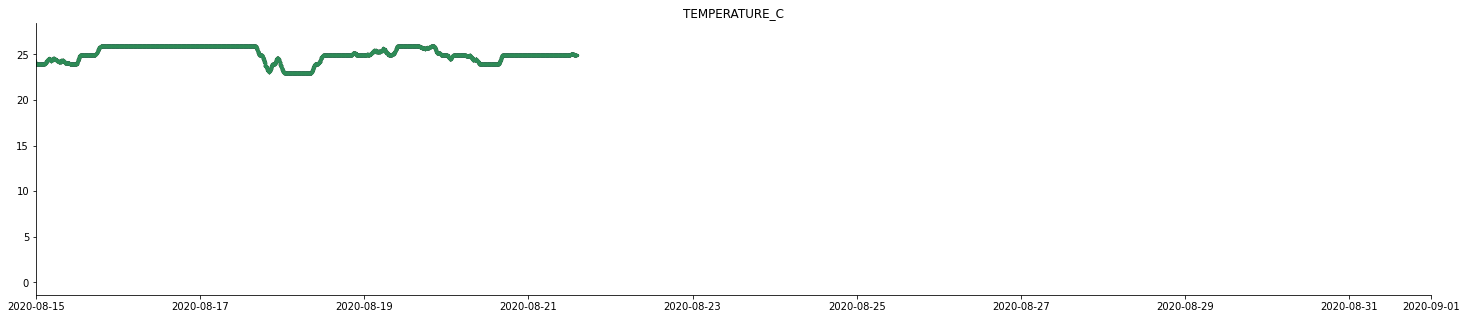

4i7679py


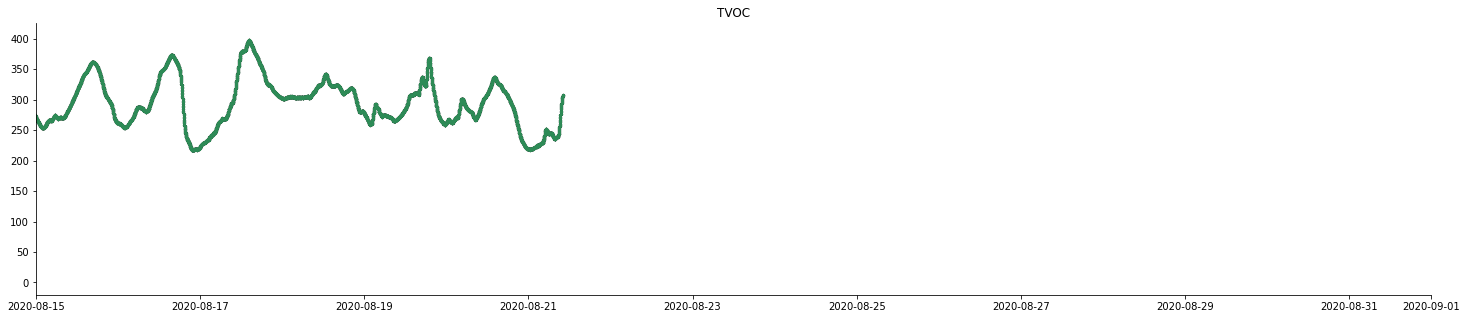

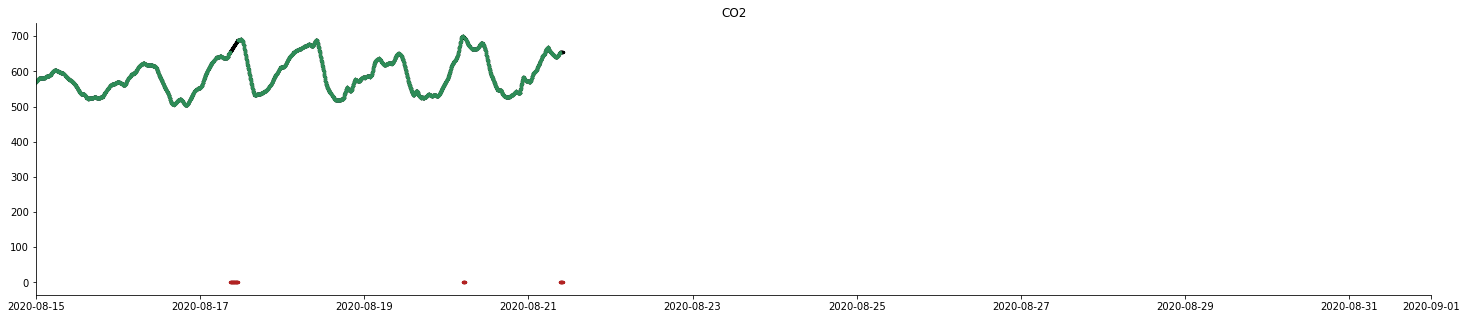

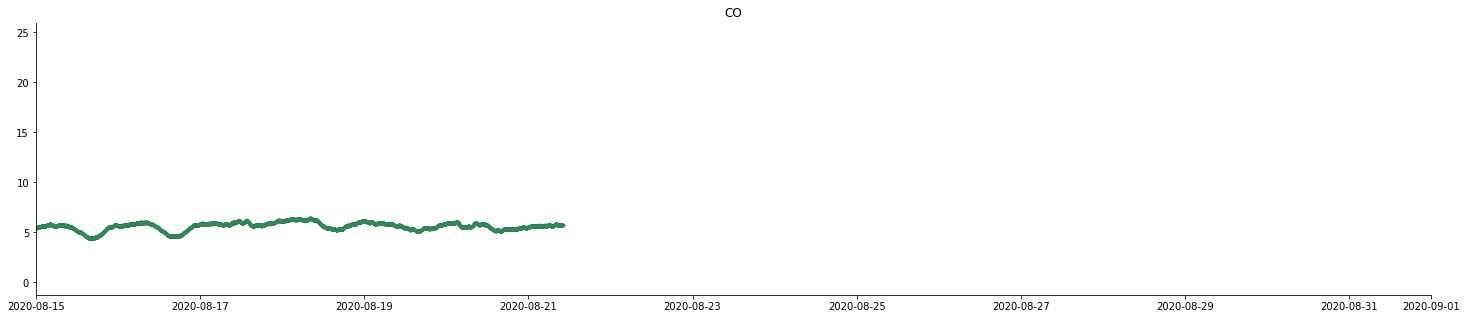

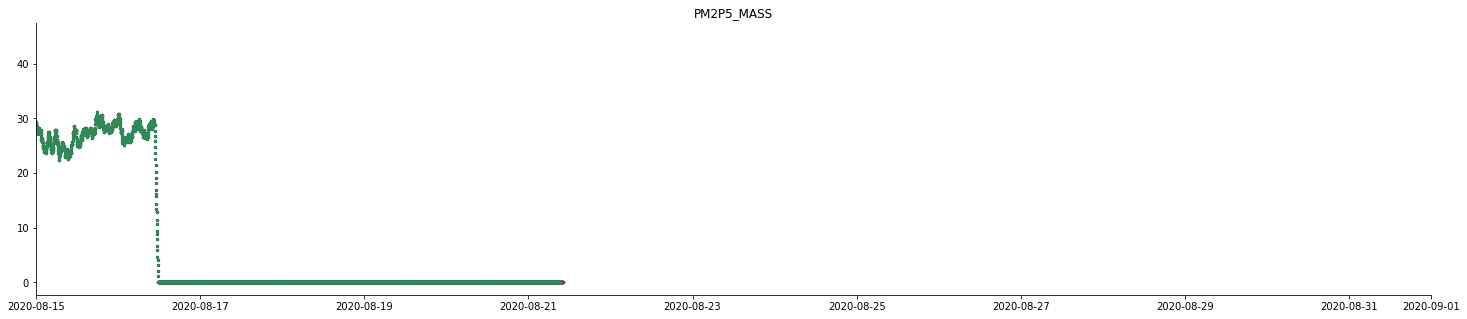

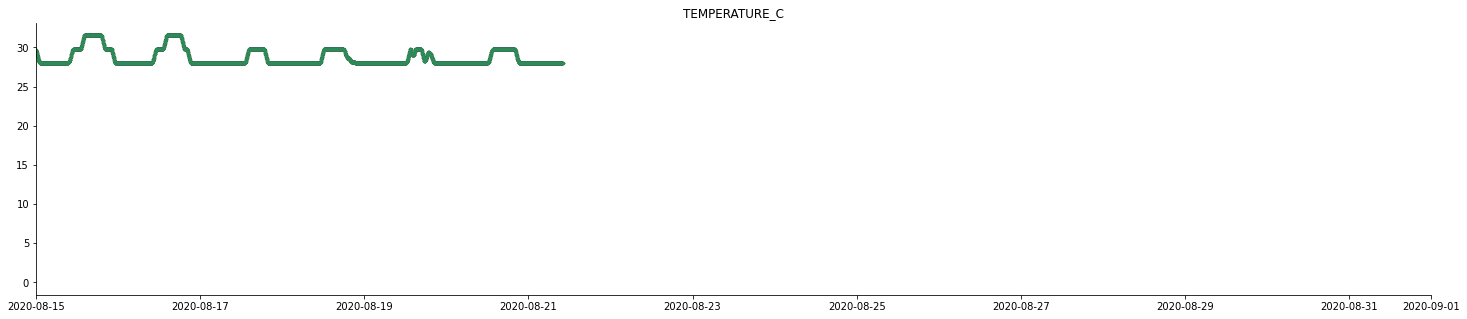

tmexej5v


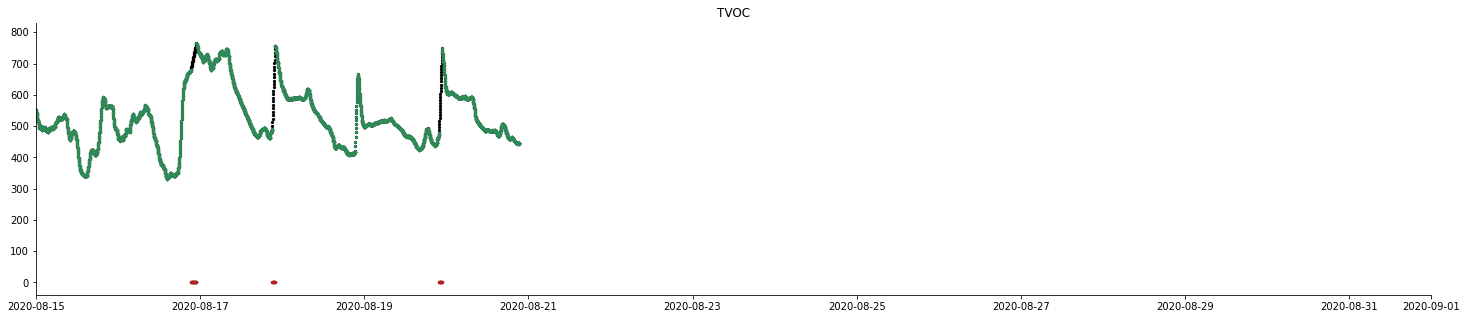

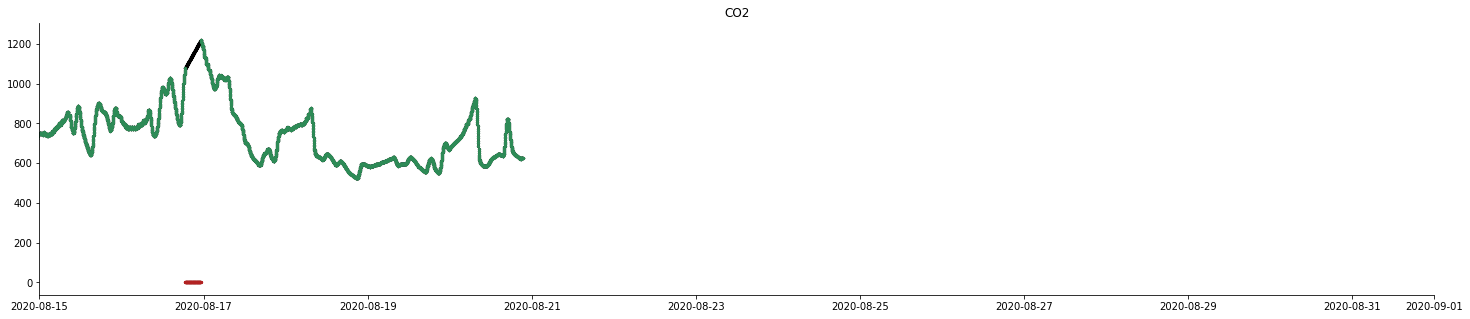

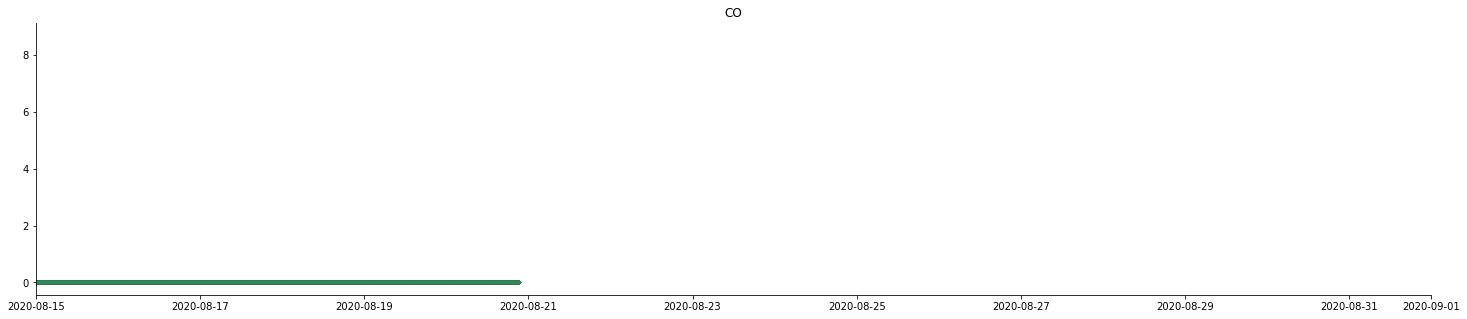

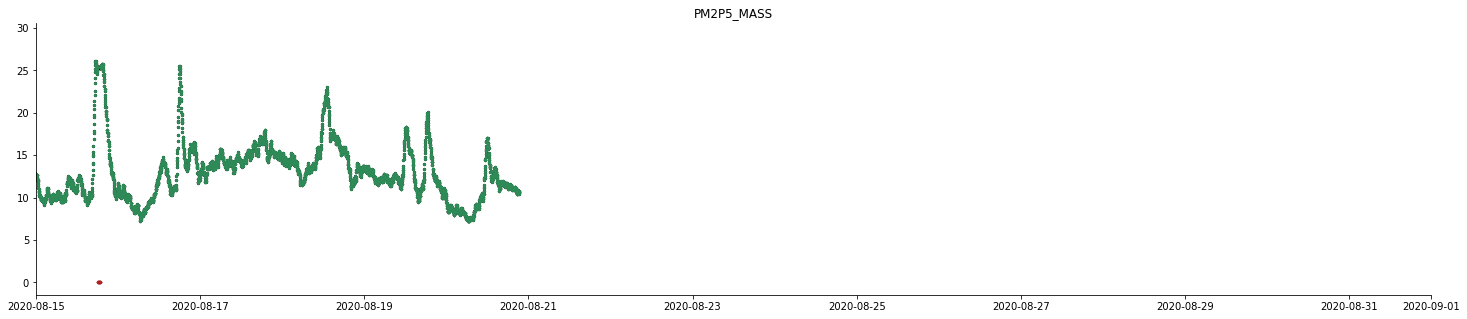

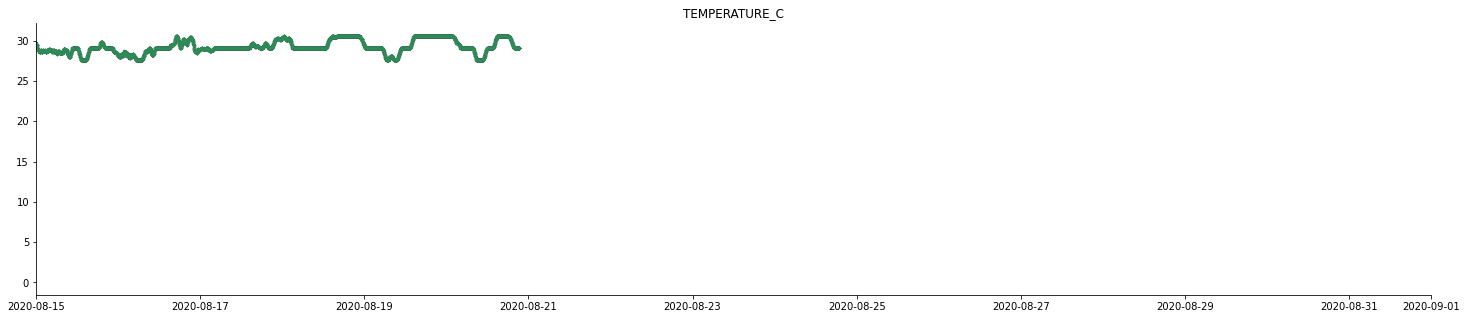

awa8uces


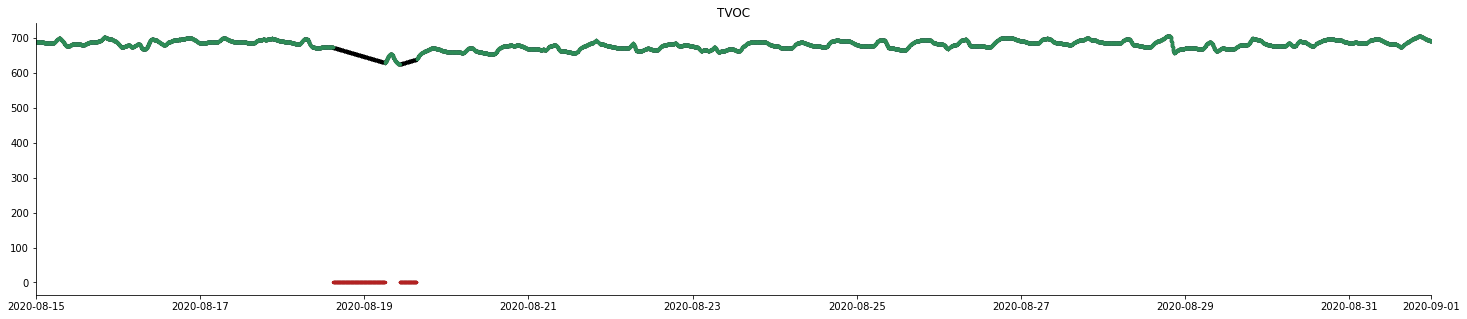

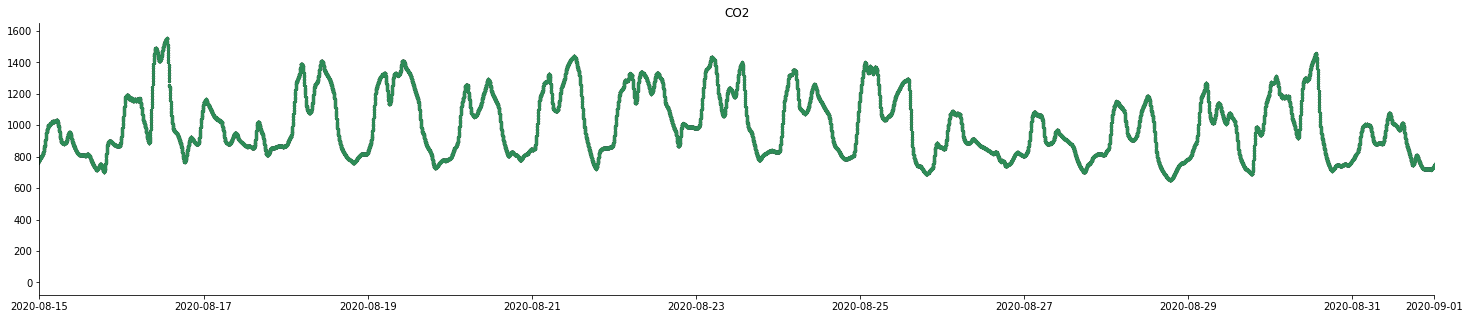

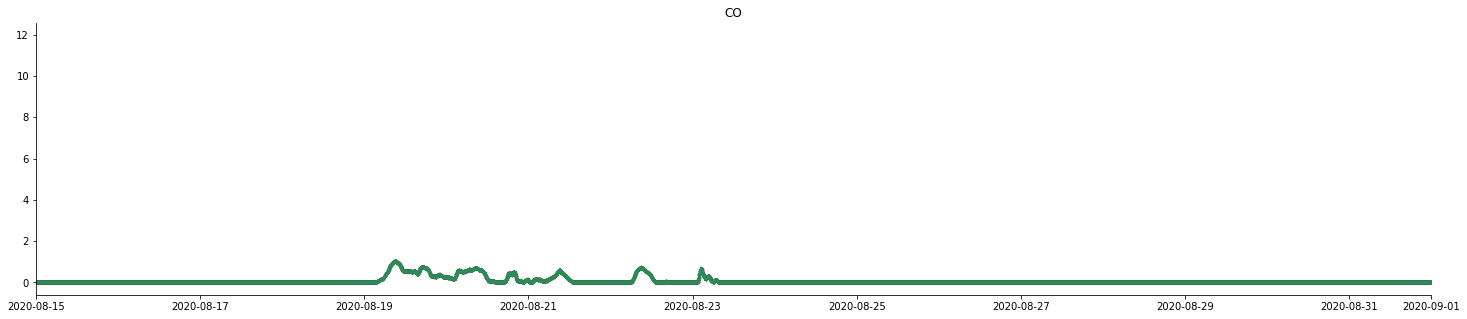

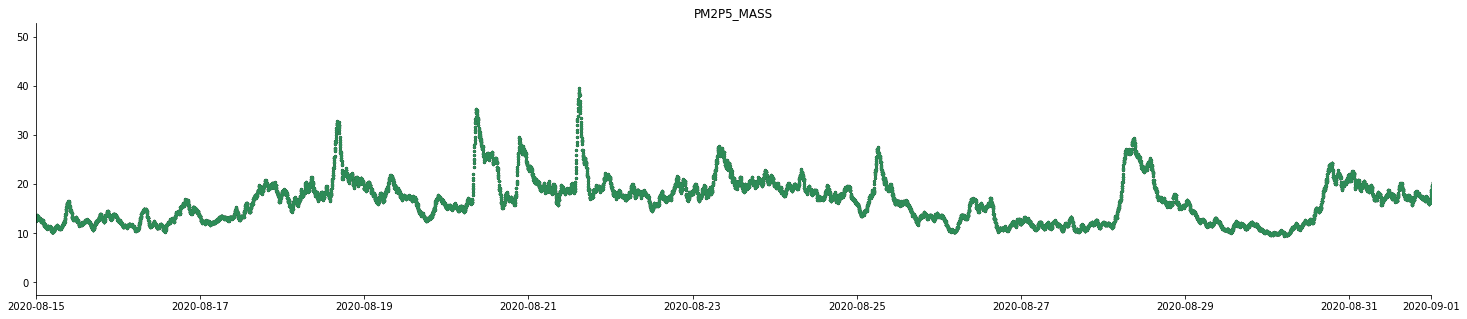

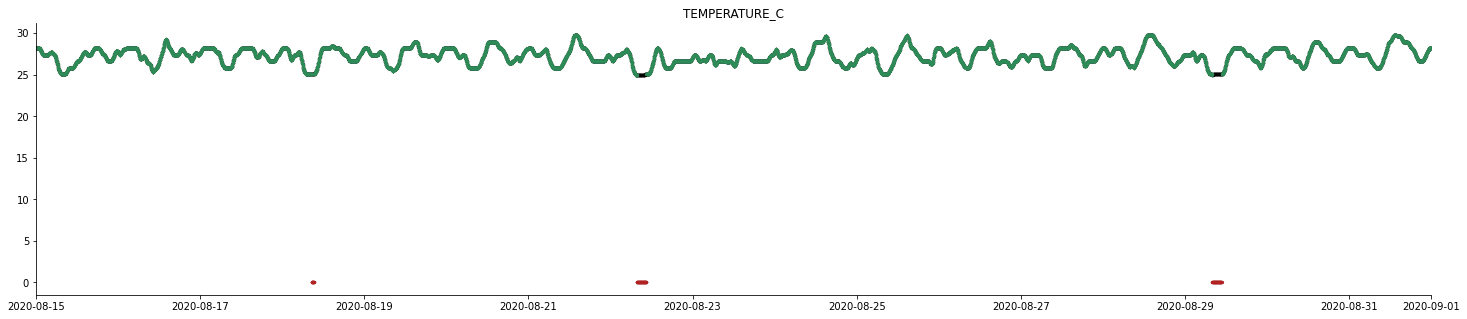

xlw5ntd5


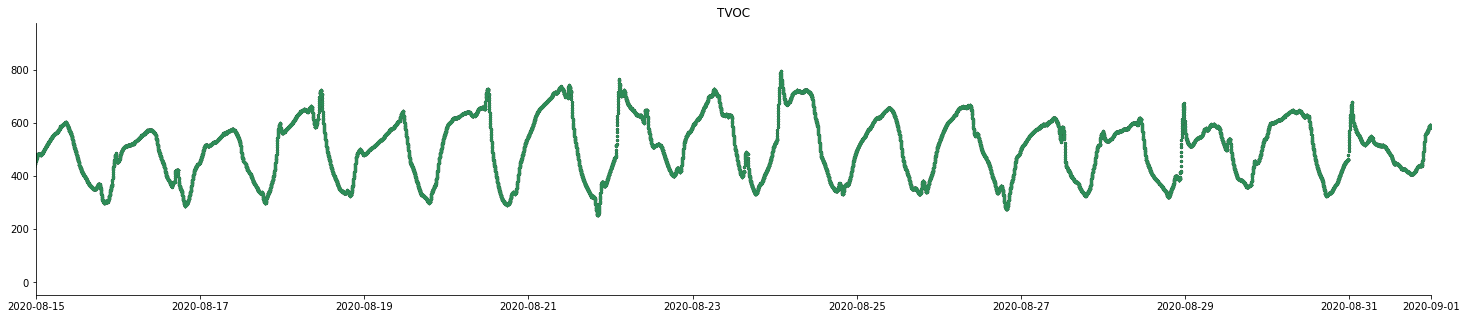

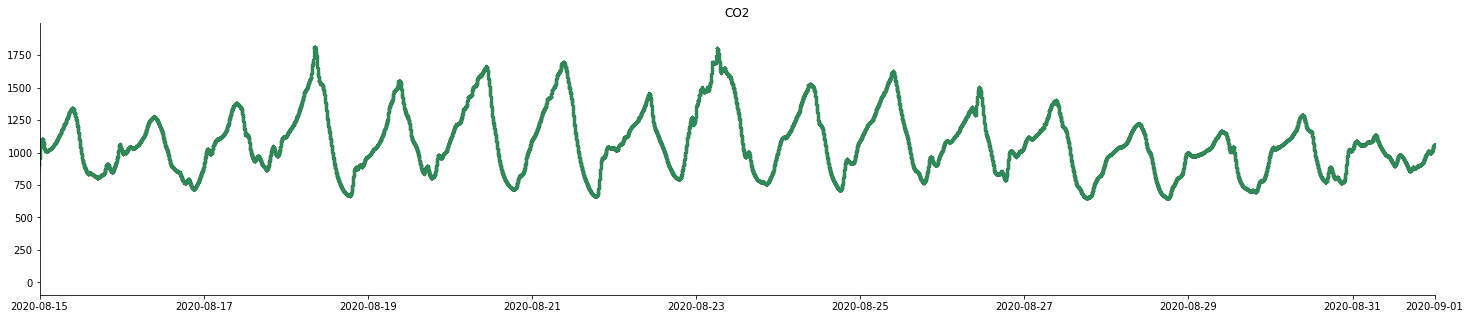

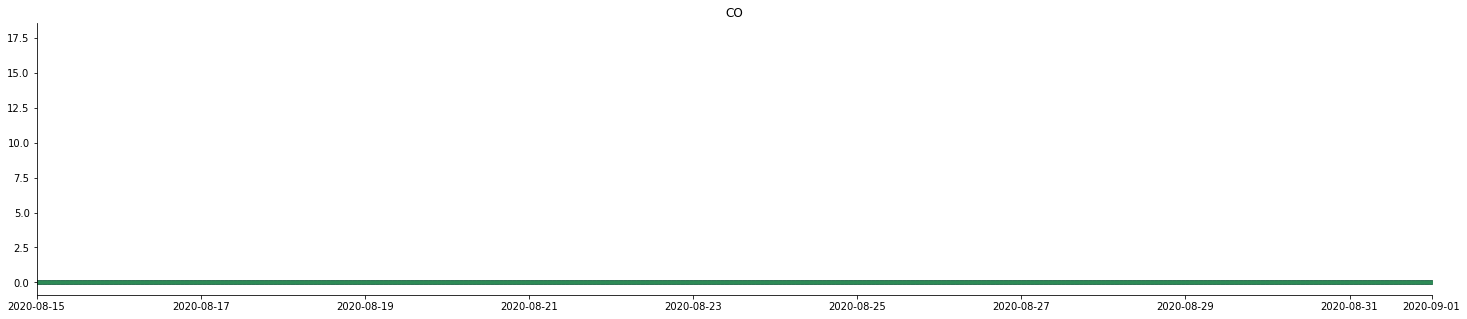

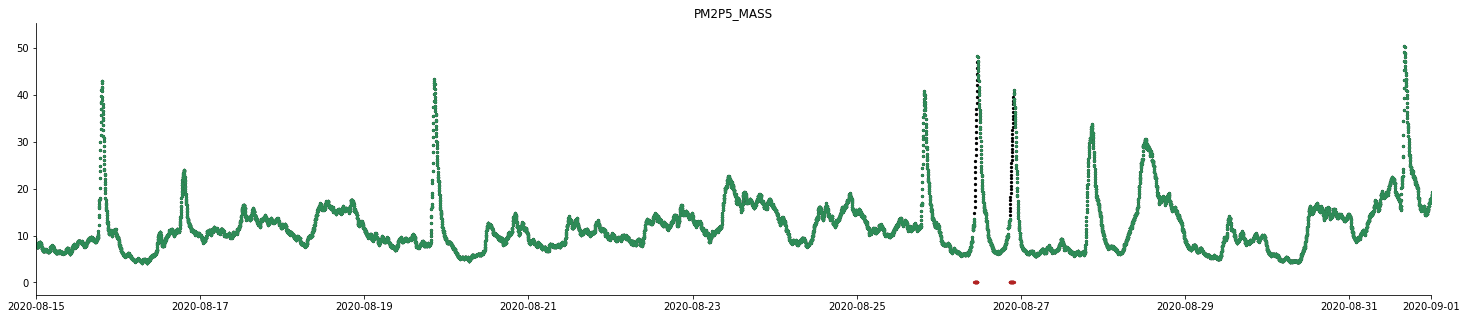

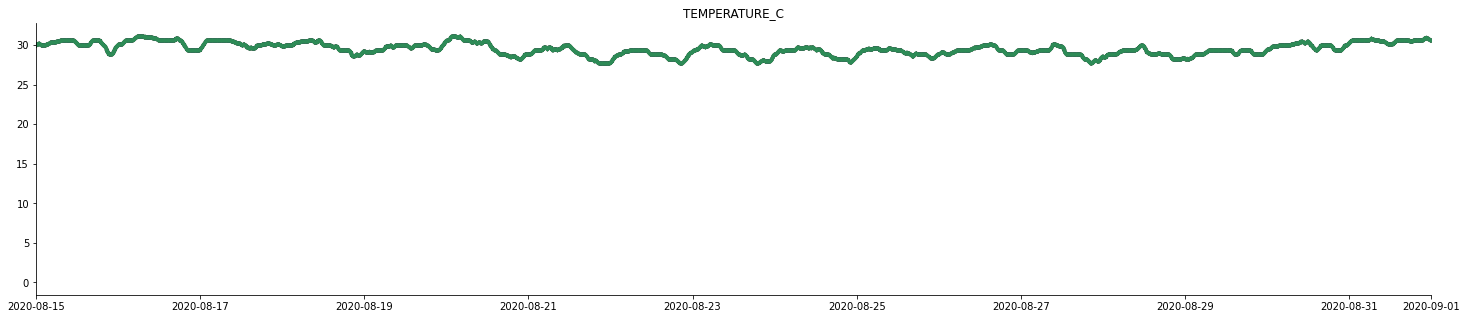

In [12]:
for pt in ["rnse61g4","4i7679py","tmexej5v","awa8uces","xlw5ntd5"]:
    print(pt)
    data_pt = data[data["beiwe"] == pt]
    for ieq_param in ["tvoc","co2","co","pm2p5_mass","temperature_c"]:
        test = manual_inspection(data_pt,ieq_param,start_time=datetime(2020,8,15),end_time=datetime(2020,9,1))

## Evaluating gap length
We don't want to use a dataset that has long gaps in data for any of the sensors because interpolating between these values would be problematic.

In [13]:
def get_gap_length(df,ieq_param):
    """
    Gets the length of the gaps
    """
    
    new_df = df.reset_index()
    new_df["start"] = new_df["timestamp"]
    new_df["end"] = new_df["timestamp"]
    new_df = (
        new_df.groupby(
            # Find where index does not follow pattern of 2 minute intervals
            new_df['timestamp'].diff().gt(pd.Timedelta(minutes=2)).cumsum()
        ).agg({
            # Get the last index value and the average of the column values
            'start': 'first', 'end' : 'last'
        })
    )
    new_df["diff"] = (new_df["end"] - new_df["start"]).dt.total_seconds()/60/60
    return new_df

In [44]:
for pt in ["rnse61g4","4i7679py","tmexej5v","awa8uces","xlw5ntd5"]:
    print(pt)
    winner = data[data["beiwe"] == pt]
    for ieq_param in ["tvoc","co2","co","pm2p5_mass","pm10_mass","temperature_c"]:
        print(ieq_param.upper())
        winner_by_param = winner[[ieq_param,"beiwe"]]
        winner_missing = winner_by_param[winner_by_param.isnull().any(axis=1)]
        temp = get_gap_length(winner_missing,ieq_param)
        print(temp)

rnse61g4
TVOC
                        start                 end      diff
timestamp                                                  
0         2020-06-15 07:58:00 2020-06-15 08:48:00  0.833333
1         2020-07-05 18:44:00 2020-07-05 19:50:00  1.100000
2         2020-07-13 07:14:00 2020-07-13 08:36:00  1.366667
3         2020-08-01 12:06:00 2020-08-01 16:34:00  4.466667
4         2020-08-03 12:06:00 2020-08-03 14:06:00  2.000000
5         2020-08-08 19:32:00 2020-08-08 21:30:00  1.966667
6         2020-08-20 19:32:00 2020-08-20 22:14:00  2.700000
CO2
                        start                 end      diff
timestamp                                                  
0         2020-07-05 17:02:00 2020-07-05 18:40:00  1.633333
1         2020-07-17 12:26:00 2020-07-17 15:18:00  2.866667
2         2020-07-18 13:10:00 2020-07-18 16:34:00  3.400000
3         2020-07-18 17:18:00 2020-07-18 19:48:00  2.500000
4         2020-07-20 15:00:00 2020-07-20 16:44:00  1.733333
5         2020-07-21 1

TVOC
                        start                 end       diff
timestamp                                                   
0         2020-06-08 23:28:00 2020-06-08 23:28:00   0.000000
1         2020-06-14 09:28:00 2020-06-14 10:48:00   1.333333
2         2020-07-25 06:34:00 2020-07-25 07:12:00   0.633333
3         2020-07-28 23:34:00 2020-07-29 08:08:00   8.566667
4         2020-08-01 06:20:00 2020-08-01 14:58:00   8.633333
5         2020-08-01 23:54:00 2020-08-02 11:58:00  12.066667
CO2
                        start                 end      diff
timestamp                                                  
0         2020-06-10 08:38:00 2020-06-10 10:42:00  2.066667
1         2020-06-11 07:52:00 2020-06-11 10:18:00  2.433333
2         2020-06-12 08:10:00 2020-06-12 10:36:00  2.433333
3         2020-06-13 07:52:00 2020-06-13 11:42:00  3.833333
4         2020-06-17 08:54:00 2020-06-17 10:38:00  1.733333
5         2020-06-24 03:08:00 2020-06-24 12:06:00  8.966667
6         2020-06-25 08

## And the winner(s) is/are...

<div class="alert-block alert alert-success">
    
xlw5ntd5
    
rnse61g4
    
</div>

# Saving Results
Using `pickle` - see this [post](https://stackoverflow.com/questions/57541522/save-load-a-dictionary)

In [7]:
import pickle

In [8]:
def save_gaps(gap_dict):
    with open(f"../data/processed/beacon-ieq_gaps-ux_s20.pickle", 'wb') as f:
        pickle.dump(gap_dict, f, pickle.HIGHEST_PROTOCOL)

In [9]:
save_gaps(pt_gaps)

## Saving Example Data

In [14]:
for pt in ["xlw5ntd5","rnse61g4","awa8uces"]:
    data_ex = data[data["beiwe"] == pt] # getting good participant data
    data_ex = data_ex[["tvoc","co2","co","pm2p5_mass","pm10_mass","temperature_c"]]
    data_ex = data_ex.interpolate(axis="rows")# interpolating on important params
    data_ex.dropna(inplace=True) # dropping the beginning and ending values that we cannot interpolate
    data_ex.to_csv(f"../data/interim/imputation/beacon-example-{pt}-ux_s20.csv")

## Testing that Loading in the File Works

In [10]:
def load_gaps(filename):
    with open(f"../data/processed/{filename}.pickle", 'rb') as f:
        return pickle.load(f)

In [ ]:
d = load_gaps("beacon-ieq_gaps-ux_s20")